In [20]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
import numpy as np
import jax.numpy as jnp
from jax import vmap, jit
import scipy as sp
from scipy.integrate import odeint
import scipy
import jax


N=400
ndims = 2

xgrid = jnp.linspace(-1,1,N)
xygrid = jnp.stack(jnp.meshgrid(*(ndims*[xgrid])),axis=-1)#.reshape(-1,ndims)
dx = xgrid[1]-xgrid[0]
#laplacian = lambda x: sp.ndimage.laplace(x,mode='constant')/dx**2
@jit
def laplacian(x):
    cderiv = lambda x: jax.scipy.signal.correlate(x,jnp.array([1.,-2,1.])/dx**2,mode='same')
    return -sum([jnp.apply_along_axis(cderiv,i,x) for i in range(ndims)])

x,y = xygrid.transpose((2,0,1))
domain = ((x>0)|(y>0))&((y>-.5)|((x-.5)**2+(y+.5)**2<.5**2))
boundary = (scipy.signal.convolve2d((~domain).astype(np.float32),jnp.ones((3,3)),mode='same',fillvalue=1)>0)&domain
boundary_vals = jnp.where(boundary,(x+y)*jnp.cos(2*x),jnp.zeros_like(x))

@jit
def pde_op(u):
    zero_grid = jnp.zeros(domain.shape)
    zero_grid = zero_grid.at[domain].set(u.reshape(-1))
    zero_grid = laplacian(zero_grid)
    return zero_grid[domain].reshape(u.shape)


from scipy.sparse.linalg import LinearOperator, eigsh

matmat = vmap(pde_op,-1,-1)

L = LinearOperator(2*(domain.sum(),),matvec = pde_op,rmatvec = pde_op,matmat=matmat,rmatmat=matmat,dtype=np.float32)

In [26]:
# phi = jnp.ones(domain.shape)[domain]
# phi = jnp.exp(-((x-.3)**2+(y-.3)**2)/.1)[domain]
sol,info = scipy.sparse.linalg.cg(L,boundary_vals[domain]/dx**2,tol=1e-4)#,maxiter=100)

In [27]:
# L_dense = L@jnp.eye(domain.sum())
# L_dense.shape
#e,v = np.linalg.eigh(L_dense)

In [28]:
print(L.shape,info)

(DeviceArray(115568, dtype=int32), DeviceArray(115568, dtype=int32)) 0


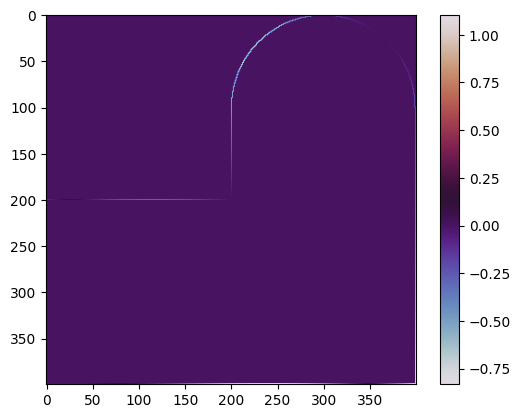

In [29]:
import matplotlib.pyplot as plt
plt.imshow(boundary_vals,cmap='twilight')
plt.colorbar()

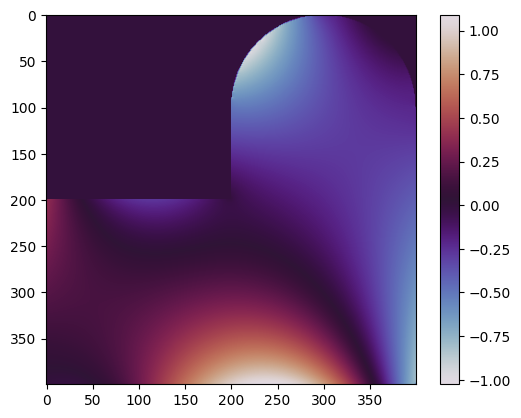

In [30]:

out_img = jnp.zeros(domain.shape)
out_img = out_img.at[domain].set(sol)

plt.imshow(out_img,cmap='twilight')
plt.colorbar()

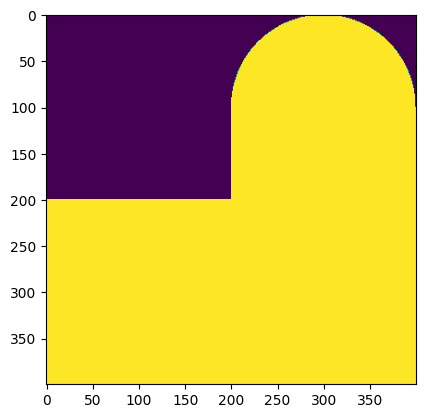

In [7]:
plt.imshow(domain)